# Project 4b - Image Warping and Mosaicing

### Dependencies

In [55]:
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from harris import get_harris_corners, dist2
from utils import computeH, warpImage, warpPoints, align_and_blend_images_custom

## Interest Point Detector

In [2]:
# Load images and points
image_left = plt.imread('../data/4a/img/IMG_8405.jpeg')
image_right = plt.imread('../data/4a/img/IMG_8406.jpeg')

# make panoramal left b&w
image_left_gray = np.mean(image_left, axis=2)
image_right_gray = np.mean(image_right, axis=2)

h_left, coords_left = get_harris_corners(image_left_gray)
h_right, coords_right = get_harris_corners(image_right_gray)

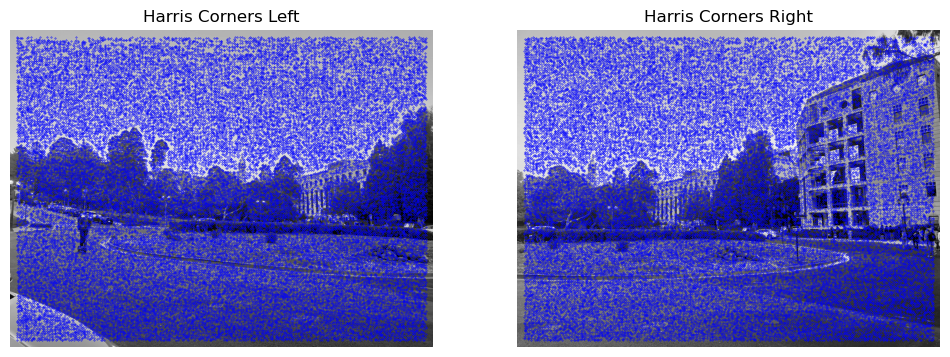

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Display Harris corners for the left image
plt.subplot(1, 2, 1)
plt.imshow(image_left_gray, cmap='gray')
plt.scatter(coords_left[1], coords_left[0], c='b', s=0.1)
plt.title('Harris Corners Left')
plt.axis('off')

# Display Harris corners for the right image
plt.subplot(1, 2, 2)
plt.imshow(image_right_gray, cmap='gray')
plt.scatter(coords_right[1], coords_right[0], c='b', s=0.1)
plt.title('Harris Corners Right')
plt.axis('off')

plt.show()

## Adaptive Non-Maximal Suppression

In [4]:
def adaptive_non_maximal_suppression(corners, h, num_points=500, c_robust=0.9):
    """
    Adaptive Non-Maximal Suppression following the approach outlined.
    
    :param corners: (2, n) array of corner coordinates (ys, xs).
    :param h: Harris response values of the image.
    :param num_points: Number of points to retain after ANMS.
    :param c_robust: Constant used in suppression condition (default = 0.9).
    :return: Array of suppressed corner coordinates.
    """
    # Extract Harris strengths for each corner point
    scores = h[corners[0], corners[1]]
    
    # Calculate pairwise distances between all corners using dist2()
    dists = dist2(corners.T, corners.T)  # corners.T is of shape (n, 2)
    
    # Broadcast comparison: f(x_i) < c_robust * f(x_j)
    larger_mask = scores[:, np.newaxis] < (c_robust * scores[np.newaxis, :])
    
    # Mask the distances where the comparison holds and set the rest to infinity
    masked_dists = np.where(larger_mask, dists, np.inf)
    
    # Calculate the minimum radius for each point
    radii = np.min(masked_dists, axis=1)
    
    # Sort points by their radii in descending order
    sorted_indices = np.argsort(-radii)
    
    # Sort the original corners based on radii
    sorted_corners = corners[:, sorted_indices]
    
    # Return the top 'num_points' corners
    return sorted_corners[:, :num_points]

# Apply Adaptive Non-Maximal Suppression to get top corners
suppressed_coords_left = adaptive_non_maximal_suppression(coords_left, h_left)
suppressed_coords_right = adaptive_non_maximal_suppression(coords_right, h_right)

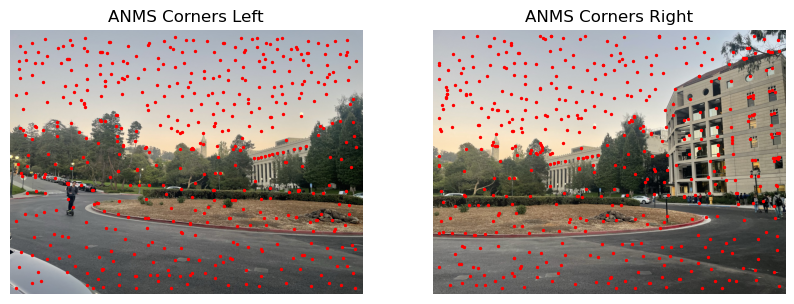

In [5]:
# Display ANMS corners
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image_left, cmap='gray')
plt.scatter(suppressed_coords_left[1], suppressed_coords_left[0], c='r', s=2)
plt.title('ANMS Corners Left')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(image_right, cmap='gray')
plt.scatter(suppressed_coords_right[1], suppressed_coords_right[0], c='r', s=2)
plt.title('ANMS Corners Right')
plt.axis('off')

plt.show()

## Feature Descriptor Extraction

In [6]:
# Redo
def extract_feature_descriptors(im, coords, patch_size=8, window_size=40, spacing=5):
    """
    Extracts bias/gain-normalized 8x8 color feature descriptors from a larger 40x40 window 
    around each interest point for each of the three color channels (R, G, B).
    
    Parameters:
    im (HxWx3 array): Colored image (RGB) from which to extract features.
    coords (2xN array): Coordinates of interest points (ys, xs).
    patch_size (int): Size of the descriptor patch (default is 8x8).
    window_size (int): Size of the larger window from which the 8x8 patch is sampled (default is 40x40).
    spacing (int): Pixel spacing between samples for the 8x8 patch (default is 5).
    
    Returns:
    descriptors (N x 192 array): Normalized color feature descriptors for each interest point.
    """
    half_window = window_size // 2
    half_patch = patch_size // 2
    descriptors = []

    # Loop over each point
    for y, x in coords.T:
        # Check for edge cases (skip points near the edges)
        if (y - half_window < 0 or y + half_window >= im.shape[0] or 
            x - half_window < 0 or x + half_window >= im.shape[1]):
            continue

        # Initialize an empty list to store the descriptor for each channel
        descriptor_channels = []
        
        # Loop over each channel (R, G, B)
        for channel in range(3):
            # Extract the 40x40 window for the current channel
            window = im[y-half_window:y+half_window, x-half_window:x+half_window, channel]

            # Blur the window to reduce aliasing
            window = gaussian_filter(window, sigma=1)

            # Sample an 8x8 patch from the window with spacing
            patch = window[::spacing, ::spacing][:patch_size, :patch_size]

            # Normalize the patch (bias/gain normalization)
            patch_mean = np.mean(patch)
            patch_std = np.std(patch)
            if patch_std > 0:
                patch = (patch - patch_mean) / patch_std

            # Flatten the patch into a vector and store it
            descriptor_channels.append(patch.flatten())

        # Concatenate descriptors from all three channels to form a single vector
        descriptor = np.concatenate(descriptor_channels)
        descriptors.append(descriptor)

    return np.array(descriptors)

descriptors_left = extract_feature_descriptors(image_left, suppressed_coords_left)
descriptors_right = extract_feature_descriptors(image_right, suppressed_coords_right)

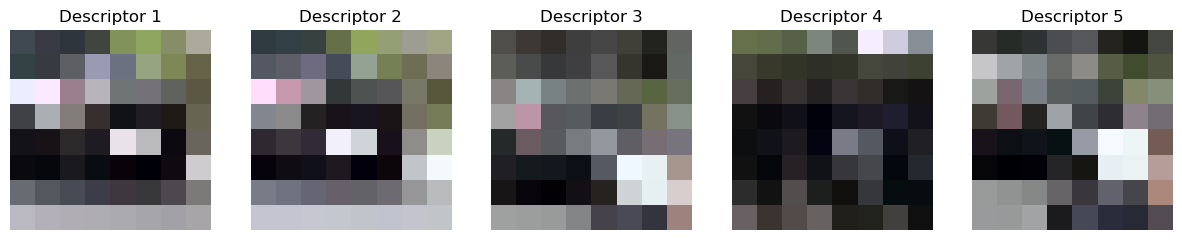

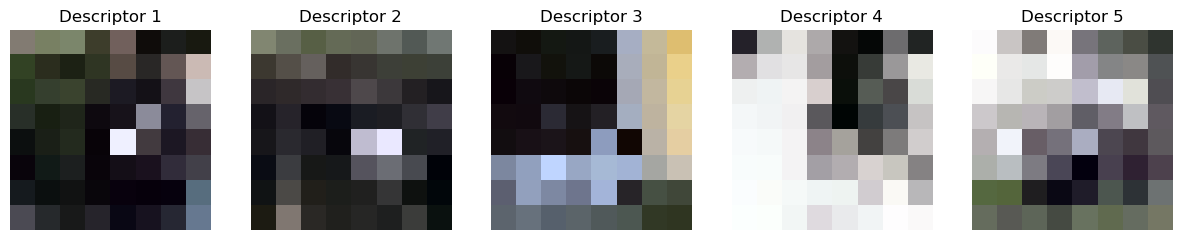

In [7]:
# Redo
def visualize_descriptors(descriptors, num_descriptors=5, patch_size=8):
    """
    Visualizes the first few descriptors as RGB images.
    
    Parameters:
    descriptors (N x 192 array): Color feature descriptors.
    num_descriptors (int): Number of descriptors to visualize (default is 5).
    patch_size (int): Size of the descriptor patch (default is 8x8).
    """
    fig, axes = plt.subplots(1, num_descriptors, figsize=(15, 5))
    
    for i in range(num_descriptors):
        descriptor = descriptors[i]
        
        # Reshape the descriptor into three 8x8 patches for R, G, B channels
        patch_r = descriptor[:patch_size*patch_size].reshape((patch_size, patch_size))
        patch_g = descriptor[patch_size*patch_size:2*patch_size*patch_size].reshape((patch_size, patch_size))
        patch_b = descriptor[2*patch_size*patch_size:].reshape((patch_size, patch_size))
        
        # Combine the patches into a single 8x8x3 RGB image
        patch_rgb = np.stack((patch_r, patch_g, patch_b), axis=-1)
        
        # Normalize the RGB image to [0, 1] for visualization
        patch_rgb = (patch_rgb - patch_rgb.min()) / (patch_rgb.max() - patch_rgb.min())
        
        # Display the RGB image
        axes[i].imshow(patch_rgb)
        axes[i].axis('off')
        axes[i].set_title(f'Descriptor {i+1}')
    
    plt.show()

visualize_descriptors(descriptors_left, num_descriptors=5)
visualize_descriptors(descriptors_right, num_descriptors=5)

## Feature Matching

In [8]:
# Redo
def match_features(descriptors1, descriptors2, ratio_threshold=0.8):
    """
    Matches color feature descriptors from two sets using Lowe's ratio test, enforcing one-to-one matching.
    
    Parameters:
    descriptors1 (N1 x 192 array): Color feature descriptors from the first image.
    descriptors2 (N2 x 192 array): Color feature descriptors from the second image.
    ratio_threshold (float): Threshold for Lowe's ratio test (default is 0.8).
    
    Returns:
    matches (list of tuples): List of matching descriptor pairs (i, j) where 
                              i is the index of the descriptor in descriptors1 and
                              j is the index of the descriptor in descriptors2.
    """
    
    matches = []
    matched_in_second_image = set()  # Track points already matched in the second image
    
    # Loop over descriptors in the first image
    for i, desc1 in enumerate(descriptors1):
        # Calculate distances to all descriptors in the second image
        distances = np.linalg.norm(descriptors2 - desc1, axis=1)
        
        # Sort distances and get the two nearest neighbors
        sorted_indices = np.argsort(distances)
        nearest_neighbor_idx = sorted_indices[0]
        second_nearest_neighbor_idx = sorted_indices[1]
        
        # Get the corresponding distances
        nearest_distance = distances[nearest_neighbor_idx]
        second_nearest_distance = distances[second_nearest_neighbor_idx]
        
        # Apply Lowe's ratio test
        if nearest_distance < ratio_threshold * second_nearest_distance:
            # Ensure one-to-one matching
            if nearest_neighbor_idx not in matched_in_second_image:
                # Register the match
                matches.append((i, nearest_neighbor_idx))
                # Mark this point as matched in the second image
                matched_in_second_image.add(nearest_neighbor_idx)
    
    return matches

matches = match_features(descriptors_left, descriptors_right)

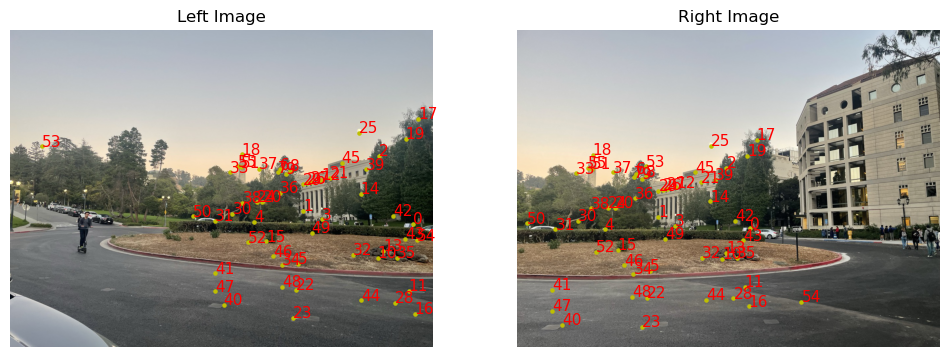

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].imshow(image_left, cmap='gray')
ax[0].set_title('Left Image')
ax[1].imshow(image_right, cmap='gray')
ax[1].set_title('Right Image')

for idx, (i, j) in enumerate(matches):
    y1, x1 = suppressed_coords_left[:, i]
    y2, x2 = suppressed_coords_right[:, j]
    
    # plot the points on the image
    ax[0].scatter(x1, y1, c='y', s=5)
    ax[1].scatter(x2, y2, c='y', s=5)

    # Remove axis
    ax[0].axis('off')
    ax[1].axis('off')

    # number the points on both images
    ax[0].text(x1, y1, str(idx), fontsize=11, color='r')
    ax[1].text(x2, y2, str(idx), fontsize=11, color='r')

plt.show()

## 4-Point RANSAC

In [80]:
def apply_homography(H, points):
    num_pts = points.shape[0]
    points_homogeneous = np.hstack((points, np.ones((num_pts, 1))))
    transformed_points = (H @ points_homogeneous.T).T
    transformed_points /= transformed_points[:, 2][:, np.newaxis]
    return transformed_points[:, :2]

import numpy as np

# def ransac_homography(matches: list, coords_left: np.ndarray, coords_right: np.ndarray, num_iterations: int = 1000, threshold: int = 5):
#     best_H = None
#     best_inliers = []
    
#     num_matches = len(matches)
    
#     for _ in range(num_iterations):
#         # Randomly select 4 matches
#         sample_indices = np.random.choice(num_matches, 4, replace=False)
#         im1_pts = coords_left[matches[sample_indices, 0]]
#         im2_pts = coords_right[matches[sample_indices, 1]]
        
#         # Compute homography matrix using the selected points
#         H = computeH(im1_pts, im2_pts)

        # height, width = image_left.shape[:2]

        # # Define corners of the original image in homogeneous coordinates
        # corners = np.array([
        #     [0, 0, 1], [width - 1, 0, 1],
        #     [width - 1, height - 1, 1], [0, height - 1, 1]
        # ]).T

        # # Warp the corners using the homography matrix
        # warped_corners = H @ corners
        # warped_corners /= warped_corners[2, :]  # Normalize homogeneous coordinates

        # # Calculate the bounding box for the warped image
        # min_x = int(np.floor(min(warped_corners[0, :])))
        # min_y = int(np.floor(min(warped_corners[1, :])))
        
#         # Warp points from image 1 to image 2 using the computed homography
#         warped_points = warpPoints(im1_pts, H, min_x, min_y)  # Assuming min_x, min_y are 0 for simplicity
        
#         # Calculate the distance between the warped points and the corresponding points in image 2
#         distances = np.linalg.norm(warped_points - im2_pts, axis=1)
        
#         # Identify inliers based on the distance threshold
#         inliers = distances < threshold
        
#         # Update the best homography if the current one has more inliers
#         if np.sum(inliers) > len(best_inliers):
#             best_H = H
#             best_inliers = inliers
#             im1_pts = im1_pts[inliers]
#             im2_pts = im2_pts[inliers]
    
#     return best_H, best_inliers, im1_pts, im2_pts


# Kalle
def warpPoints_Ransac(points, H):
   
    """
    Warps 2D points using a homography matrix.

    Parameters:
    points (Nx2 array): Array of 2D points (x, y) to be warped.
    H (3x3 array): Homography matrix to apply to the points.

    Returns:
    warped_points (Nx2 array): Warped 2D points after applying the homography.
    """
    num_points = points.shape[0]
    
    # Convert points to homogeneous coordinates (add a column of 1's)
    homogeneous_points = np.hstack([points, np.ones((num_points, 1))])  # Shape (N, 3)

    # Apply the homography to the points (result will be (3, N))
    warped_points = H @ homogeneous_points.T  # Shape (3, N)
   

    # Normalize the points (divide by the third coordinate w)
    warped_points /= warped_points[2, :]  # Normalize by the third coordinate

    # Return the 2D x, y coordinates (Nx2)
    return warped_points[:2, :].T  # Shape will be (N, 2)

def ransac_homography(coords_left, coords_right, matches, num_iterations=1000, threshold=5):
    """
    Performs RANSAC to estimate the homography matrix H between two sets of points (coords_left, coords_right).
    
    Parameters:
    coords_left (2xN array): Coordinates of interest points from the left image (ys, xs).
    coords_right (2xN array): Coordinates of interest points from the right image (ys, xs).
    matches (list of tuples): List of matching pairs between the two sets of points.
    num_iterations (int): Number of RANSAC iterations.
    threshold (float): Threshold to consider a point an inlier.
    
    Returns:
    best_H (3x3 array): Estimated homography matrix.
    best_inliers (list): List of inlier indices.
    best_im1_pts (array): Best matched points from image 1.
    best_im2_pts (array): Best matched points from image 2.
    """
    # Step 1: Extract all matching points
    pts1 = []
    pts2 = []
    
    for i, (idx1, idx2) in enumerate(matches):
        pts1.append(coords_left[:, idx1])  # Get point from left image
        pts2.append(coords_right[:, idx2])  # Get point from right image

    pts1 = np.array(pts1)
    pts2 = np.array(pts2)

    best_H = None
    max_inliers = 0
    best_inliers = []

    for iter in range(num_iterations):
        # Randomly select 4 matches
        random_indices = np.random.choice(len(matches), 4, replace=False)
        selected_pts1 = pts1[random_indices]
        selected_pts2 = pts2[random_indices]

        # Compute homography
        H_temp = computeH(selected_pts1, selected_pts2)

        inliers = []
        for idx in range(len(pts1)):
            warped_pt1 = warpPoints_Ransac(np.array([pts1[idx]]), H_temp)[0]
            dist = np.linalg.norm(warped_pt1 - pts2[idx])

            if dist < threshold:
                inliers.append(idx)

        # Update best homography if this iteration has the most inliers
        if len(inliers) > max_inliers:
            max_inliers = len(inliers)
            best_H = H_temp
            best_inliers = inliers

    # Recompute homography using all inliers
    if max_inliers < 4:
        raise ValueError("Not enough inliers to compute a homography.")

    best_im1_pts = pts1[best_inliers]
    best_im2_pts = pts2[best_inliers]
    best_H = computeH(best_im1_pts, best_im2_pts)

    return best_H, best_inliers, best_im1_pts, best_im2_pts

# Example usage
# Assuming matches, suppressed_coords_left, and suppressed_coords_right are defined
best_H, best_inliers, best_im1_pts, best_im2_pts = ransac_homography(coords_left, coords_right, matches, num_iterations=1000, threshold=5)
print(best_H)
# print(best_inliers)
# print(im1_pts)
# print(im2_pts)

[[-8.69684369e-01  1.56045967e-02  4.67498765e+02]
 [-1.64808522e+00  1.75245431e-02  9.03510586e+02]
 [-1.84828872e-03  3.23910235e-05  1.00000000e+00]]


In [11]:
# Correct H2
# [[ 2.39875461e+00 -1.07312014e-01 -1.24265452e+03]
# [ 6.13879567e-01  1.91272209e+00 -4.89303216e+02]
# [ 1.10968064e-03 -7.69086616e-05  1.00000000e+00]]

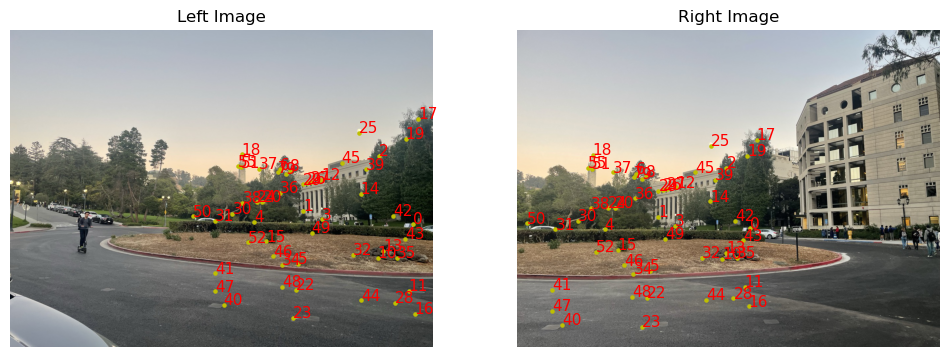

In [35]:
# Initialize lists to store inlier coordinates
inlier_coords_left = []
inlier_coords_right = []

plt.figure(figsize=(12, 6))

# Display the left image
plt.subplot(1, 2, 1)
plt.imshow(image_left, cmap='gray')
plt.title('Left Image')

# Display the right image
plt.subplot(1, 2, 2)
plt.imshow(image_right, cmap='gray')
plt.title('Right Image')

# Loop through matches and process inliers
for idx, (i, j) in enumerate(matches):
    if best_inliers[idx]:
        y1, x1 = suppressed_coords_left[:, i]
        y2, x2 = suppressed_coords_right[:, j]
        
        # Append inlier coordinates to the lists
        inlier_coords_left.append([y1, x1])
        inlier_coords_right.append([y2, x2])
        
        # Plot inliers on the left image
        plt.subplot(1, 2, 1)
        plt.axis('off')
        plt.scatter(x1, y1, c='y', s=5)
        plt.text(x1, y1, str(idx), fontsize=11, color='r')
        
        # Plot inliers on the right image
        plt.subplot(1, 2, 2)
        plt.axis('off')
        plt.scatter(x2, y2, c='y', s=5)
        plt.text(x2, y2, str(idx), fontsize=11, color='r')

plt.show()

In [36]:
# Convert inlier coordinates lists to numpy arrays
inlier_coords_left = np.array(inlier_coords_left)
inlier_coords_right = np.array(inlier_coords_right)

# Print the inlier coordinates
print("Inlier coordinates in left image:")
print(inlier_coords_left)

print("Inlier coordinates in right image:")
print(inlier_coords_right)

Inlier coordinates in left image:
[[ 587 1221]
 [ 548  888]
 [ 380 1117]
 [ 573  943]
 [ 580  739]
 [ 707  871]
 [ 422  816]
 [ 431  811]
 [ 426  847]
 [ 435  835]
 [ 689 1113]
 [ 790 1207]
 [ 454  941]
 [ 669 1129]
 [ 495 1061]
 [ 639  776]
 [ 859 1225]
 [ 269 1236]
 [ 376  701]
 [ 330 1198]
 [ 520  764]
 [ 787  866]
 [ 871  857]
 [ 520  746]
 [ 311 1056]
 [ 464  899]
 [ 461  912]
 [ 826 1164]
 [ 467  886]
 [ 556  673]
 [ 578  620]
 [ 681 1039]
 [ 711  824]
 [ 689 1171]
 [ 492  816]
 [ 420  753]
 [ 522  703]
 [ 422 1076]
 [ 832  646]
 [ 736  621]
 [ 562 1160]
 [ 631 1196]
 [ 818 1062]
 [ 401 1004]
 [ 685  797]
 [ 791  620]
 [ 778  823]
 [ 613  913]
 [ 564  554]
 [ 415  700]
 [ 642  719]
 [ 412  691]]
Inlier coordinates in right image:
[[600 704]
 [566 426]
 [417 633]
 [592 477]
 [603 264]
 [728 401]
 [436 358]
 [446 352]
 [443 390]
 [451 377]
 [693 619]
 [777 688]
 [476 481]
 [674 632]
 [518 584]
 [665 303]
 [836 700]
 [332 724]
 [377 228]
 [381 695]
 [538 295]
 [811 392]
 [899 377]
 

In [32]:
# # Test
# # Function to select points by given indices
# def select_points_by_index(matches, coords_left, coords_right, indices):
#     selected_im1_pts = []
#     selected_im2_pts = []

#     for idx in indices:
#         i, j = matches[idx]  # Extract match at the given index
#         y1, x1 = coords_left[:, i]
#         y2, x2 = coords_right[:, j]

#         selected_im1_pts.append([x1, y1])
#         selected_im2_pts.append([x2, y2])

#     return np.array(selected_im1_pts), np.array(selected_im2_pts)

# # Plot function for selected points
# def plot_selected_points(image_left, image_right, selected_im1_pts, selected_im2_pts):
#     fig, ax = plt.subplots(1, 2, figsize=(12, 6))

#     # Plot for the left image
#     ax[0].imshow(image_left, cmap='gray')
#     ax[0].set_title('Left Image')

#     for idx, (x1, y1) in enumerate(selected_im1_pts):
#         ax[0].scatter(x1, y1, c='y', s=10)
#         ax[0].text(x1, y1, str(idx), fontsize=12, color='r')

#     ax[0].axis('off')

#     # Plot for the right image
#     ax[1].imshow(image_right, cmap='gray')
#     ax[1].set_title('Right Image')

#     for idx, (x2, y2) in enumerate(selected_im2_pts):
#         ax[1].scatter(x2, y2, c='y', s=10)
#         ax[1].text(x2, y2, str(idx), fontsize=12, color='r')

#     ax[1].axis('off')
#     plt.show()

# # Example usage
# indices_to_pick = [25, 23, 40, 50]  # Indices of matches to select
# im1_pts, im2_pts = select_points_by_index(matches, suppressed_coords_left, suppressed_coords_right, indices_to_pick)

# # Plot selected points on both images
# plot_selected_points(image_left, image_right, im1_pts, im2_pts)

# # Now you can compute the homography with these selected points
# H_selected = computeH(im1_pts, im2_pts)
# print("Computed Homography Matrix:")
# print(H_selected)

In [15]:
# Correct H2
# [[ 2.39875461e+00 -1.07312014e-01 -1.24265452e+03]
# [ 6.13879567e-01  1.91272209e+00 -4.89303216e+02]
# [ 1.10968064e-03 -7.69086616e-05  1.00000000e+00]]

In [37]:
# Warp the image
image_left_warped, min_x, min_y = warpImage(image_left, best_H)

# Warp the points
warped_points = warpPoints(im1_pts, best_H, min_x, min_y)

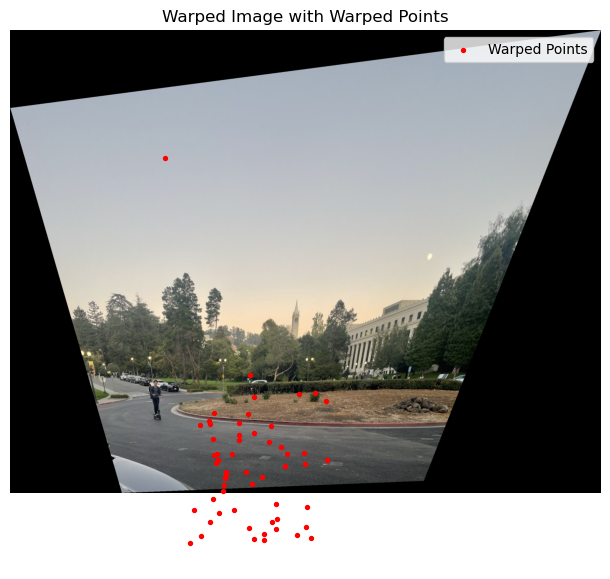

In [38]:
plt.figure(figsize=(10, 7))

# Display the warped image
plt.imshow(image_left_warped, cmap='gray')
plt.scatter(warped_points[:, 0], warped_points[:, 1], c='r', s=8, label='Warped Points')

plt.legend()
plt.title('Warped Image with Warped Points')
plt.axis('off')
plt.show()

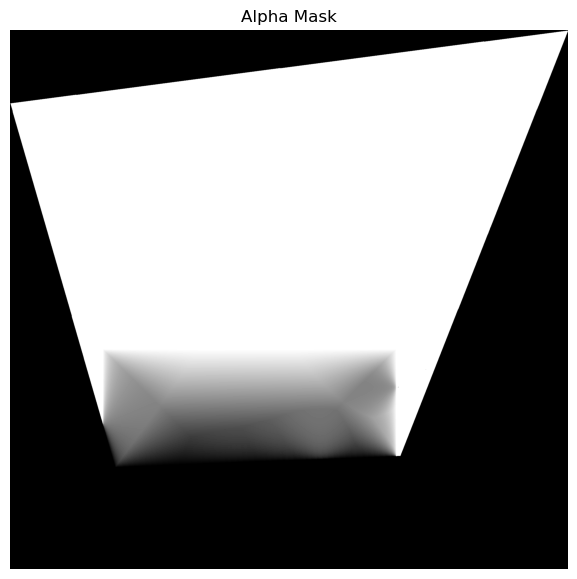

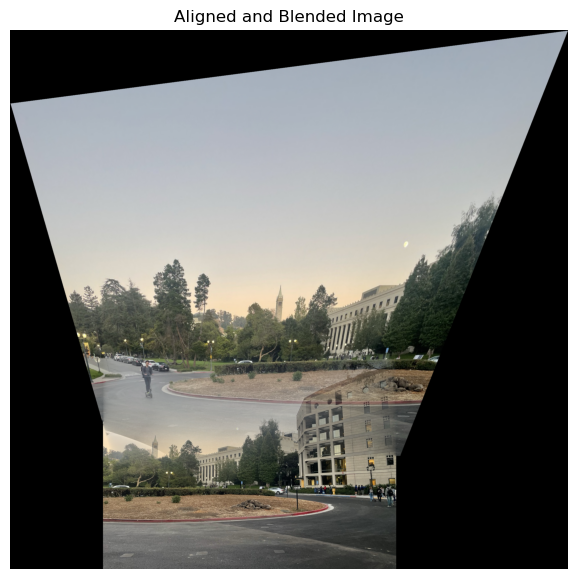

In [39]:
# Align and blend the images
result_image = align_and_blend_images_custom(image_left_warped, image_right, warped_points, im2_pts)

# Display the result
plt.figure(figsize=(10, 7))
plt.imshow(result_image)
plt.title('Aligned and Blended Image')
plt.axis('off')
plt.show()

In [ ]:
# Old, "working"
def ransac_homography(matches, coords_left, coords_right, num_iterations=1000, threshold=5):
    best_H = None
    max_inliers = 0
    best_inliers = []
    best_im1_pts = []
    best_im2_pts = []

    for _ in range(num_iterations):
        # Randomly select 4 matches
        sample_indices = np.random.choice(len(matches), 4, replace=False)
        sample_matches = [matches[i] for i in sample_indices]

        im1_pts = np.array([coords_left[:, i] for i, _ in sample_matches])
        im2_pts = np.array([coords_right[:, j] for _, j in sample_matches])

        # Compute homography
        H = computeH(im1_pts, im2_pts)

        # Apply homography to all points
        all_im1_pts = np.array([coords_left[:, i] for i, _ in matches])
        all_im2_pts = np.array([coords_right[:, j] for _, j in matches])
        transformed_pts = apply_homography(H, all_im1_pts)

        # Compute inliers
        distances = np.linalg.norm(transformed_pts - all_im2_pts, axis=1)
        inliers = distances < threshold
        num_inliers = np.sum(inliers)

        if num_inliers > max_inliers:
            max_inliers = num_inliers
            best_H = H
            best_inliers = inliers
            best_im1_pts = all_im1_pts
            best_im2_pts = all_im2_pts

    return best_H, best_inliers, best_im1_pts, best_im2_pts